In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # Suprime avisos

In [27]:
def plot_unfiltered(path,name, color,ax):
    # Carrega o CSV; substitua 'seuarquivo.csv' pelo caminho do seu arquivo
    df = pd.read_csv(path, parse_dates=['Post Timestamp', 'Reply Timestamp'])

    df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]


    unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])

    # Gera uma nova coluna com o início do mês para cada post
    unique_posts['Start of Month'] = unique_posts['Post Timestamp'].dt.to_period('M').apply(lambda r: r.start_time)

    # Conta quantos posts únicos por mês
    monthly_counts = unique_posts.groupby('Start of Month').size()

    # Cria o line plot
    ax.plot(monthly_counts.index, monthly_counts.values,label = name,color = color)
    return None


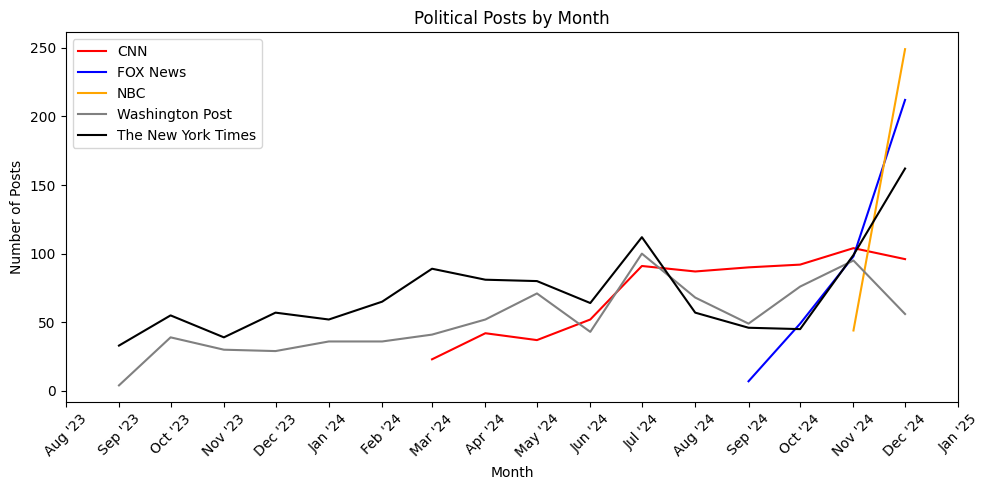

In [58]:

fig, ax = plt.subplots(figsize=(10,5))

plot_unfiltered("politics_posts_and_replies_CNN.csv", "CNN","red",ax)
plot_unfiltered("politics_posts_and_replies_FOX.csv", "FOX News","blue",ax)
plot_unfiltered("politics_posts_and_replies_NBC.csv", "NBC","orange",ax)
plot_unfiltered("politics_posts_and_replies_TWP.csv", "Washington Post","gray",ax)
plot_unfiltered("politics_posts_and_replies_TNYT.csv", "The New York Times","black",ax)





ax.set_title('Political Posts by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Posts')

all_months = pd.date_range(start='2023-08-01', end="2025-01-01", freq='MS')

ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)


plt.legend(loc= "best")

plt.tight_layout()
plt.show()

In [28]:
def plot_overall_keyword_percentage_weekly_smoothed(paths, keyword, color, ax, window=4):
    all_frames = []
    # Loop por cada arquivo para ler, filtrar e preparar os dados
    for path in paths:
        df = pd.read_csv(path, parse_dates=['Post Timestamp', 'Reply Timestamp'])
        df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]
        
        # Se for o dataset da FOX, substitui texto vazio pelo link
        if "FOX" in path:
            # Verifica onde 'Post Text' está vazio ou nulo e substitui pelo 'Post Link'
            df['Post Text'] = df["Post Link"].copy()
        
        # Remove duplicatas baseadas no post
        unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])
        unique_posts['Start of Week'] = unique_posts['Post Timestamp']\
                                        .dt.to_period('W')\
                                        .apply(lambda r: r.start_time)
        all_frames.append(unique_posts)

    # Combina dados de todos os datasets
    combined = pd.concat(all_frames, ignore_index=True)

    # Conta total de posts por semana
    total_weekly = combined.groupby('Start of Week').size()

    # Filtra posts que contêm a palavra-chave (case-insensitive)
    keyword_posts = combined[combined['Post Text'].str.contains(keyword, case=False, na=False)]
    keyword_weekly = keyword_posts.groupby('Start of Week').size()

    # Cria uma sequência de semanas completas no intervalo para reindexar
    all_weeks = pd.date_range(start='2023-09-01', end='2025-01-01', freq='W-MON')
    total_weekly = total_weekly.reindex(all_weeks, fill_value=0)
    keyword_weekly = keyword_weekly.reindex(all_weeks, fill_value=0)

    # Calcula a porcentagem semanal
    percentage = (keyword_weekly / total_weekly.replace(0, pd.NA)) * 100
    percentage = percentage.fillna(0)

    # Aplica suavização com média móvel
    smoothed = percentage.rolling(window=window, min_periods=1, center=True).mean()

    # Plota a linha suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{keyword}", color=color)


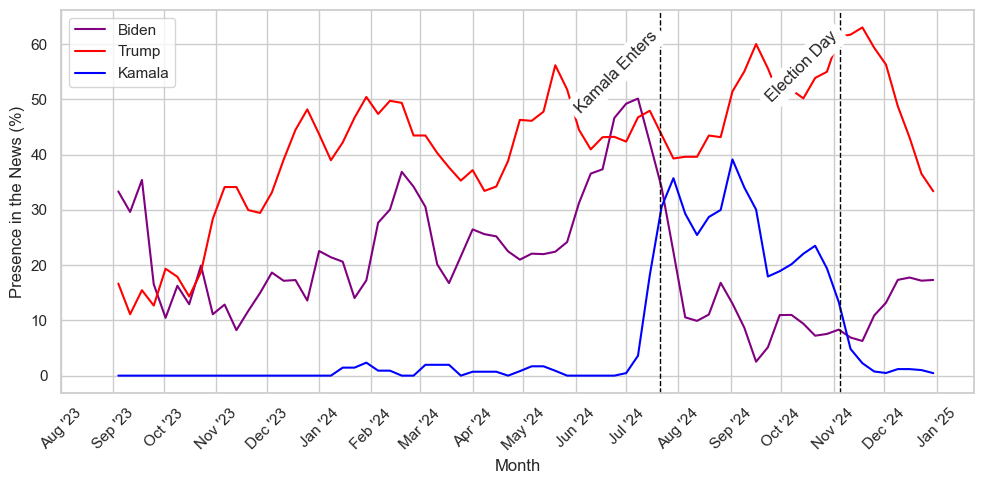

In [32]:
# Lista de caminhos para seus datasets
paths = [
    "politics_posts_and_replies_CNN.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv"
]

fig, ax = plt.subplots(figsize=(10,5))
w = 3
# Plota a porcentagem agregada suavizada semanalmente
plot_overall_keyword_percentage_weekly_smoothed(paths, "Biden", "purple", ax,window=w)
plot_overall_keyword_percentage_weekly_smoothed(paths, "Trump", "red", ax,window=w)
plot_overall_keyword_percentage_weekly_smoothed(paths, "Kamala", "blue", ax, window=w)


#ax.set_title('Smoothed Percentage of Posts About Key Figures')
ax.set_xlabel('Month')
ax.set_ylabel('Presence in the News (%)')


event_dates = {
    "Kamala Enters": "2024-07-21",
    "Election Day": "2024-11-05"
}

ymax = ax.get_ylim()[1]

for event, date_str in event_dates.items():
    event_date = pd.Timestamp(date_str)
    ax.axvline(event_date, color='black', linestyle='--', linewidth=1)
    ax.text(event_date, ymax * 0.95, event,
            rotation=45,
            verticalalignment='top',
            horizontalalignment='right',
            backgroundcolor='white')

# Define ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [100]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Baixa o léxico VADER na primeira vez
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

texts = [
    "I love this product!",
    "Shit",
    "The event was okay, nothing special."
]

for text in texts:
    scores = sia.polarity_scores(text)
    print(f"Texto: {text}")
    print(f"Pontuações de Sentimento: {scores}\n")


Texto: I love this product!
Pontuações de Sentimento: {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696}

Texto: Shit
Pontuações de Sentimento: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5574}

Texto: The event was okay, nothing special.
Pontuações de Sentimento: {'neg': 0.277, 'neu': 0.49, 'pos': 0.233, 'compound': -0.092}



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [71]:
def plot_average_reply_sentiment_weekly_keyword(paths, keyword, color, ax, window=4, lab = None):

    if lab == None:
        lab = keyword
    analyzer = SentimentIntensityAnalyzer()
    all_frames = []
    
    for path in paths:
        # Ler CSV e garantir que 'Reply Timestamp' é datetime
        df = pd.read_csv(path, parse_dates=['Reply Timestamp', 'Post Timestamp'])
        
        # Converter explicitamente para datetime e descartar linhas sem data válida
        df['Reply Timestamp'] = pd.to_datetime(df['Reply Timestamp'], errors='coerce')
        df = df.dropna(subset=['Reply Timestamp'])
        
        # Filtrar pelo intervalo de datas baseado em 'Reply Timestamp'
        df = df[(df['Reply Timestamp'] >= '2023-09-01') & (df['Reply Timestamp'] <= '2025-01-01')]
        
        # Se for dataset da FOX, substituir texto vazio pelo link
        if "FOX" in path:
            df['Post Text'] = df["Post Link"]
        
        # Filtrar linhas onde o post contém a palavra-chave (case-insensitive)
        keyword_mask = df['Post Text'].str.contains(keyword, case=False, na=False)
        df = df[keyword_mask]
        
        # Se não houver dados após filtrar, pular este arquivo
        if df.empty:
            continue

        # Calcular o sentimento composto de cada reply
        df['reply_compound'] = df['Reply Text'].apply(
            lambda text: analyzer.polarity_scores(text)['compound'] if pd.notnull(text) else None
        )
        df = df.dropna(subset=['reply_compound'])
        
        # Criar coluna com o início da semana baseado em 'Reply Timestamp'
        df['Start of Week'] = df['Reply Timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
        
        # Selecionar apenas as colunas necessárias para análise
        all_frames.append(df[['Start of Week', 'reply_compound']])
    
    # Verifica se há dados coletados
    if not all_frames:
        print("Nenhum dado disponível após filtragem.")
        return
    
    # Combinar dados de todos os arquivos
    combined = pd.concat(all_frames, ignore_index=True)
    
    # Calcular a média semanal do sentimento composto
    weekly_avg = combined.groupby('Start of Week')['reply_compound'].mean()
    
    # Aplicar média móvel para suavização
    smoothed = weekly_avg.rolling(window=window, min_periods=1, center=True).mean()
    
    # Plotar a série suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{lab}", color=color)

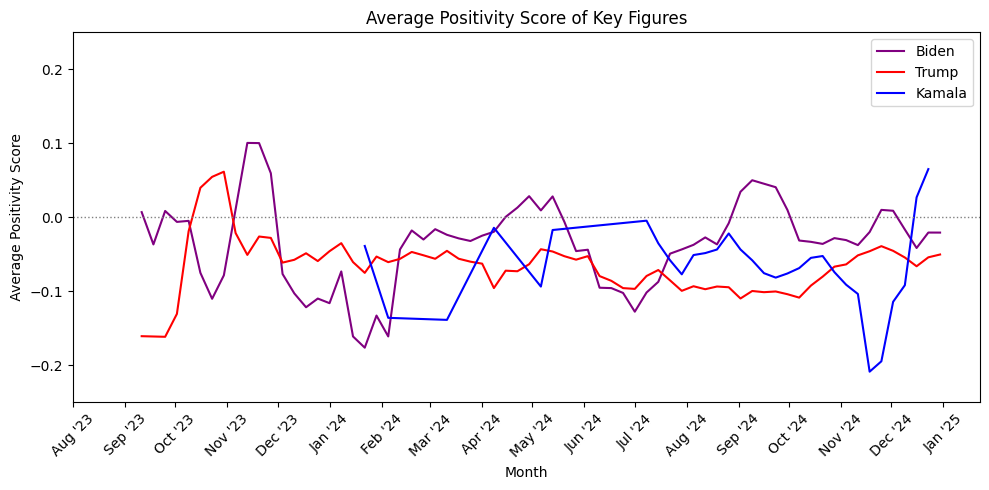

In [70]:
# Lista de caminhos para seus arquivos CSV
paths = [
    "politics_posts_and_replies_CNN.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv"
]

fig, ax = plt.subplots(figsize=(10,5))

# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(paths, "Biden", "purple", ax)
plot_average_reply_sentiment_weekly_keyword(paths, "Trump", "red", ax)
plot_average_reply_sentiment_weekly_keyword(paths, "Kamala", "blue", ax)

ax.set_title('Average Positivity Score of Key Figures')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.25, 0.25)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


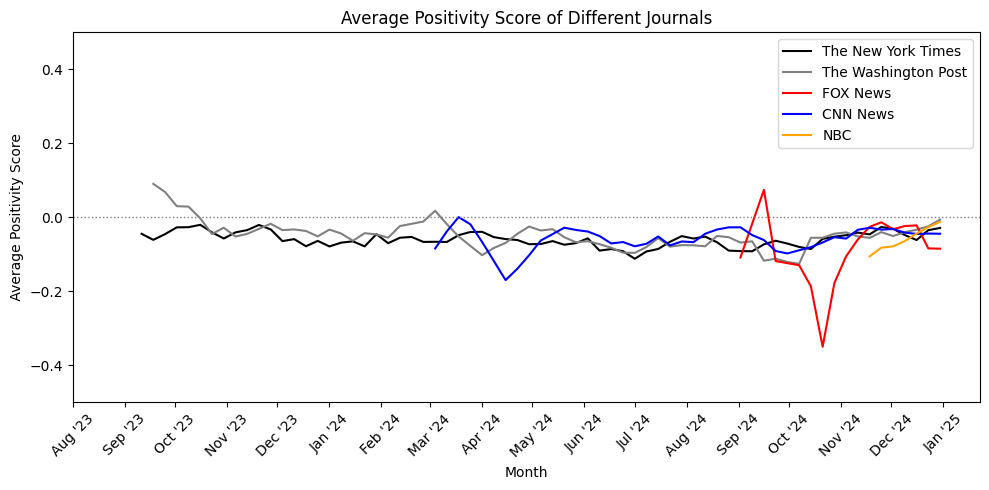

In [81]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))

# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], "", "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], "", "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], "", "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], "", "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], "", "orange", ax, lab="NBC")





ax.set_title('Average Positivity Score of Different Journals')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


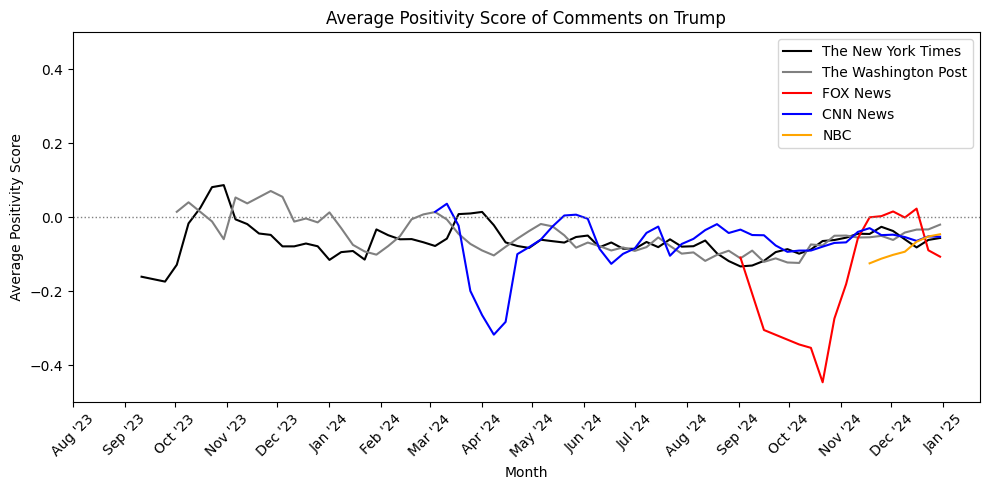

In [82]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Trump"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


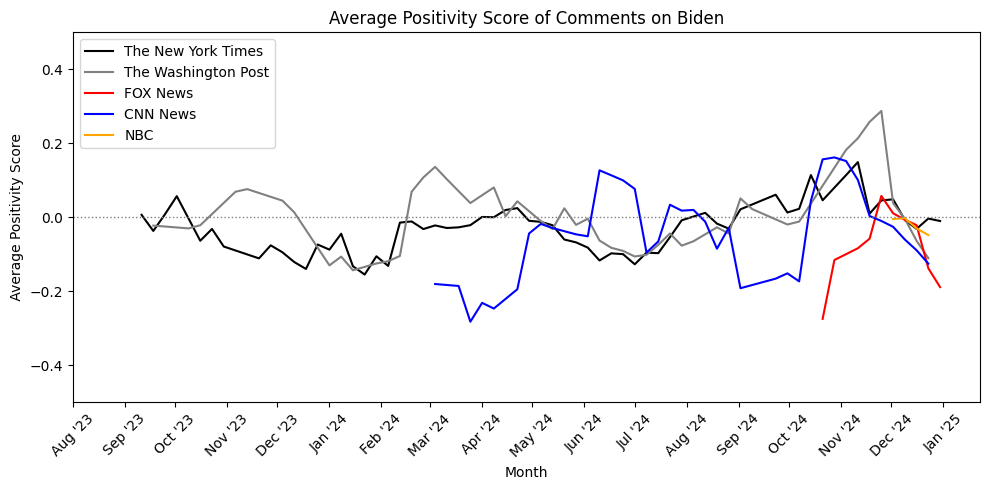

In [83]:
# Lista de caminhos para seus arquivos CSV

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Biden"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


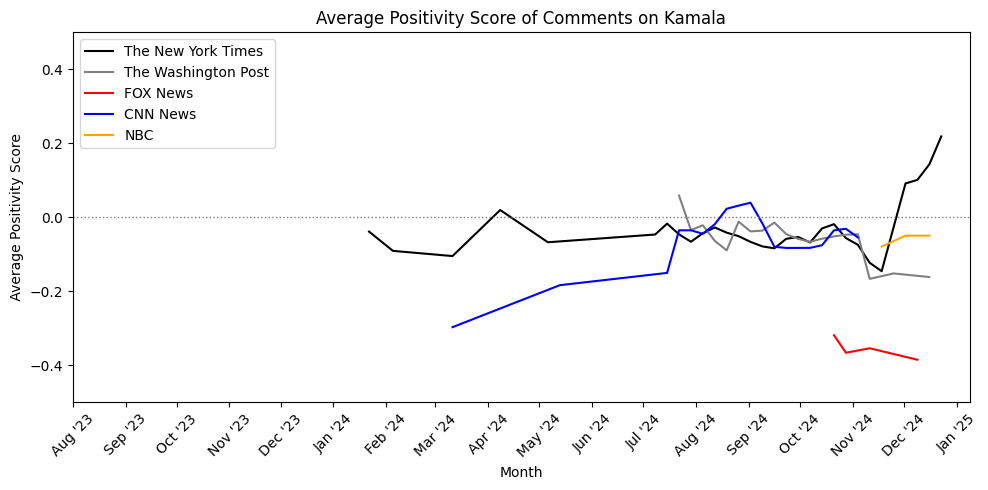

In [84]:
# Lista de caminhos para seus arquivos CSV

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Kamala"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


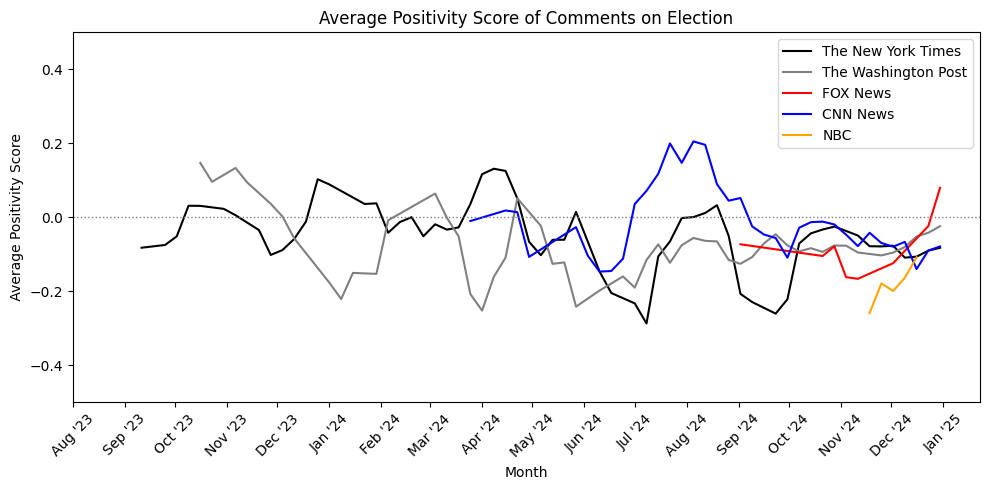

In [87]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Election"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


1      0.125315
2      0.077762
3      0.062098
4      0.052867
5      0.053706
         ...   
258    0.000280
290    0.000280
294    0.000280
325    0.000280
376    0.000280
Name: proportion, Length: 192, dtype: float64


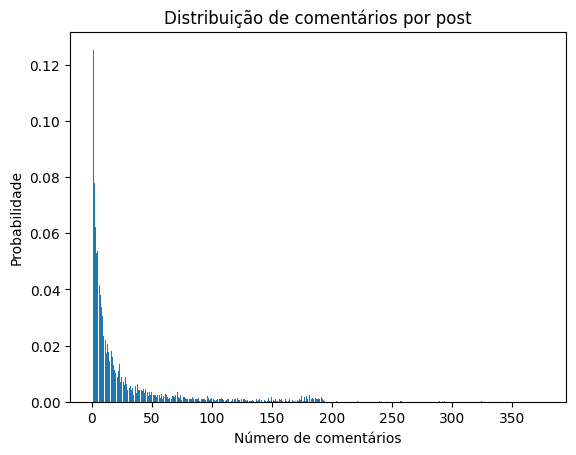

In [5]:

# Lista com os nomes dos arquivos CSV
arquivos = [
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_CNN.csv"
]

# Lê cada arquivo e armazena os DataFrames em uma lista
lista_dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

# Concatena todos os DataFrames em um único DataFrame
df_total = pd.concat(lista_dfs, ignore_index=True)

# Agrupa pelos posts (usando "Post Link" para identificar posts únicos) e conta quantos comentários cada um recebeu
comentarios_por_post = df_total.groupby("Post Link").size()

# Calcula a distribuição: probabilidade de ter x comentários
distribuicao = comentarios_por_post.value_counts(normalize=True).sort_index()

# Mostra a distribuição no console
print(distribuicao)

# Opcional: visualiza a distribuição em um gráfico de barras
plt.bar(distribuicao.index, distribuicao.values)
plt.xlabel("Número de comentários")
plt.ylabel("Probabilidade")
plt.title("Distribuição de comentários por post")

plt.show()


1      0.125315
2      0.203077
3      0.265175
4      0.318042
5      0.371748
         ...   
258    0.998881
290    0.999161
294    0.999441
325    0.999720
376    1.000000
Name: proportion, Length: 192, dtype: float64


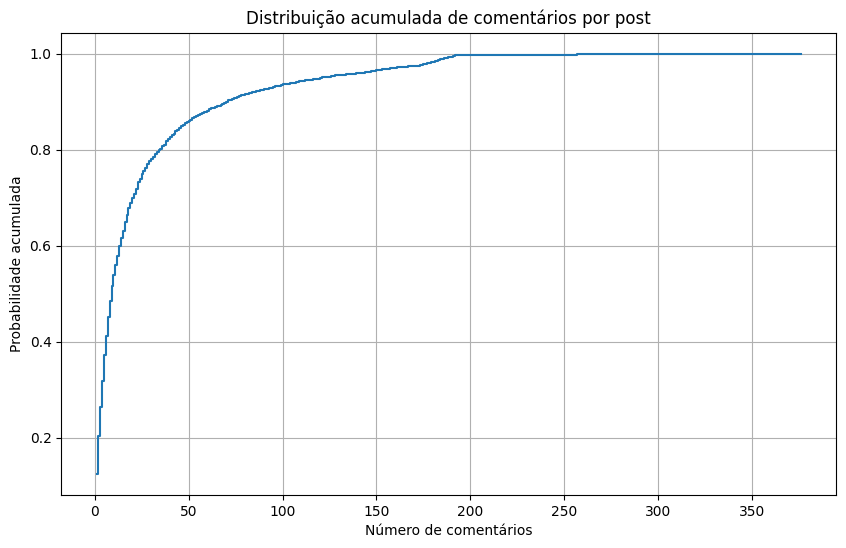

In [6]:
# Lista com os nomes dos arquivos CSV
arquivos = [
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_CNN.csv"
]

# Lê cada arquivo e armazena os DataFrames em uma lista
lista_dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

# Concatena todos os DataFrames em um único DataFrame
df_total = pd.concat(lista_dfs, ignore_index=True)

# Agrupa pelos posts usando "Post Link" para identificar posts únicos
comentarios_por_post = df_total.groupby("Post Link").size()

# Calcula a distribuição: probabilidade de ter x comentários
distribuicao = comentarios_por_post.value_counts(normalize=True).sort_index()

# Calcula a distribuição acumulada
distribuicao_acumulada = distribuicao.cumsum()

# Exibe a distribuição acumulada no console
print(distribuicao_acumulada)

# Plota a distribuição acumulada
plt.figure(figsize=(10,6))
plt.step(distribuicao_acumulada.index, distribuicao_acumulada.values, where='post')
plt.xlabel("Número de comentários")
plt.ylabel("Probabilidade acumulada")
plt.title("Distribuição acumulada de comentários por post")
plt.grid(True)
plt.show()

In [7]:
import pandas as pd

# Lista com os nomes dos arquivos CSV
arquivos = [
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_CNN.csv"
]

# Lê cada arquivo e armazena os DataFrames em uma lista
lista_dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

# Concatena todos os DataFrames em um único DataFrame
df_total = pd.concat(lista_dfs, ignore_index=True)

# Agrupa pelos posts usando "Post Link" para identificar posts únicos e conta comentários
comentarios_por_post = df_total.groupby("Post Link").size()

# Identifica os posts com mais de 25 comentários
posts_com_mais_de_25 = comentarios_por_post[comentarios_por_post > 25].index

# Filtra o DataFrame para incluir somente os posts com mais de 25 comentários
df_filtrado = df_total[df_total["Post Link"].isin(posts_com_mais_de_25)]

# Salva os dados filtrados em um novo arquivo CSV
df_filtrado.to_csv("posts_com_mais_de_25_comentarios.csv", index=False)

print(f"Salvo {len(df_filtrado)} linhas no arquivo 'posts_com_mais_de_25_comentarios.csv'")


Salvo 69529 linhas no arquivo 'posts_com_mais_de_25_comentarios.csv'


In [8]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Inicializa o analisador de sentimentos
analyzer = SentimentIntensityAnalyzer()

# Carrega o dataset de posts com mais de 25 comentários
df = pd.read_csv("posts_com_mais_de_25_comentarios.csv", parse_dates=['Post Timestamp', 'Reply Timestamp'])

# Calcular o sentimento composto para cada reply
df['reply_compound'] = df['Reply Text'].apply(
    lambda text: analyzer.polarity_scores(text)['compound'] if pd.notnull(text) else None
)

# Remove comentários sem sentimento calculado
df = df.dropna(subset=['reply_compound'])

# Agrupar por post para calcular a média do sentimento dos comentários
agrupado = df.groupby("Post Link").agg({
    "Post Text": "first",             # Título do post
    "Post Timestamp": "first",        # Timestamp do post
    "reply_compound": "mean"          # Média do sentimento dos comentários
}).reset_index()

# Renomear a coluna para clareza
agrupado.rename(columns={"reply_compound": "average_sentiment"}, inplace=True)

# Ordenar pela negatividade (ou seja, pelos valores mais baixos de sentimento primeiro)
agrupado_sorted = agrupado.sort_values("average_sentiment")

# Selecionar colunas de interesse e salvar em um novo CSV
agrupado_sorted[["Post Text", "Post Timestamp", "Post Link", "average_sentiment"]] \
    .to_csv("average_sentiment_by_post.csv", index=False)

print("Arquivo 'average_sentiment_by_post.csv' criado com sucesso!")


Arquivo 'average_sentiment_by_post.csv' criado com sucesso!


In [20]:
import nltk

# Baixa os recursos necessários do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')  # Caso ainda não tenha baixado para análises de sentimento
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string

# Baixa os recursos necessários do NLTK (caso ainda não tenha sido feito)
nltk.download('punkt')
nltk.download('stopwords')

# Carrega o dataset com os posts filtrados
df = pd.read_csv("average_sentiment_by_post.csv")

# Combina todos os textos dos posts em uma única string
all_text = " ".join(df['Post Text'].astype(str).tolist())

# Tokeniza o texto
tokens = word_tokenize(all_text)

# Define a lista de stopwords em inglês padrão
stop_words = set(stopwords.words('english'))

# Define uma lista de stopwords personalizadas
additional_stopwords = {
    'would', 'said', 'say', 'says', 'also', 'could', 'get', 'got',
    'like', 'might', 'must', 'need', 'one', 'said', 'see', 'said',
    'should', 'still', 'take', 'took', 'tell', 'tells', 'tell',
    'think', 'thinks', 'used', 'use', 'using', 'way', 'ways',
    'work', 'worked', 'working', 'works'
}

# Combina as stopwords padrão com as personalizadas
stop_words = stop_words.union(additional_stopwords)

# Filtra tokens: remove pontuação, stopwords, e palavras com 2 ou menos caracteres
filtered_words = [
    word.lower() for word in tokens 
    if word.isalpha() and word.lower() not in stop_words and len(word) > 2
]

# Conta a frequência das palavras
word_counts = Counter(filtered_words)

# Exibe as 20 palavras mais comuns
most_common_words = word_counts.most_common(20)
print("As 20 palavras mais comuns são:")
for word, count in most_common_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As 20 palavras mais comuns são:
trump: 652
donald: 370
president: 266
biden: 190
news: 129
house: 119
former: 114
new: 113
breaking: 93
election: 84
campaign: 69
harris: 67
presidential: 64
first: 62
office: 62
court: 60
administration: 56
kamala: 54
white: 54
people: 52


In [7]:
from nltk.stem import WordNetLemmatizer

# Baixa o recurso necessário para lematização
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Aplica a lematização
filtered_words = [
    lemmatizer.lemmatize(word.lower()) for word in tokens 
    if word.isalpha() and word.lower() not in stop_words and len(word) > 2
]

# Conta a frequência das palavras
word_counts = Counter(filtered_words)

print(len(word_counts))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


4129


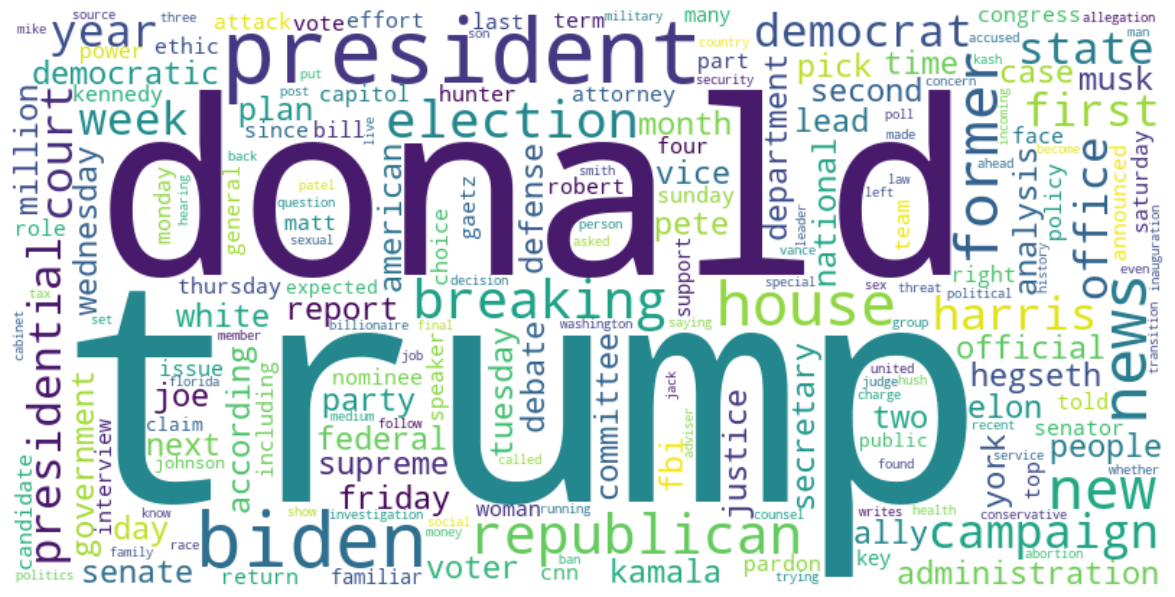

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gera a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)


# Exibe a nuvem de palavras
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Top 20 words by weighted sentiment score:
attend: 0.54
nadler: 0.53
pardoned: 0.47
tax: 0.42
steel: 0.40
democracy: 0.37
giving: 0.36
loan: 0.34
decided: 0.32
judiciary: 0.32
chairman: 0.30
mourning: 0.29
jerrold: 0.29
heeding: 0.29
already: 0.28
dnc: 0.28
endorse: 0.27
grown: 0.27
spokesperson: 0.27
orbit: 0.25


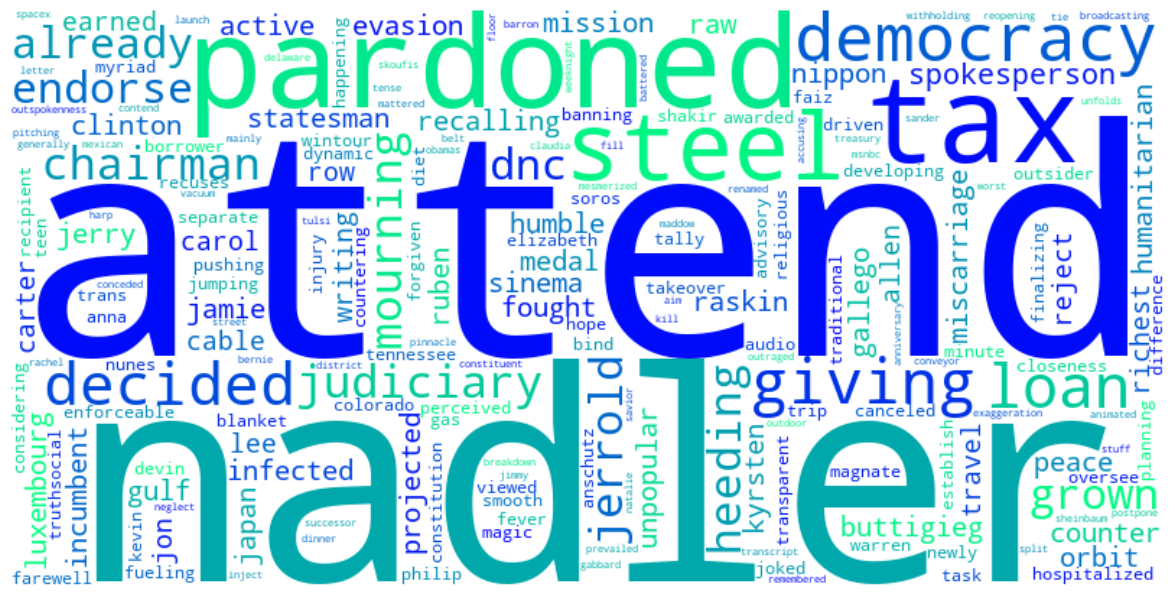

In [40]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

###############################################################################
# 1. Setup & Data Loading
###############################################################################
# If you haven't already downloaded the needed NLTK data, do so:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Read your dataset (CSV) with the columns: 
#    "Post Text","Post Timestamp","Post Link","average_sentiment"
df = pd.read_csv("average_sentiment_by_post.csv")

###############################################################################
# 2. Define Stopwords and Initialize Lemmatizer
###############################################################################
stop_words = set(stopwords.words('english'))

# Custom stopwords you wish to exclude
additional_stopwords = {
    'would', 'said', 'say', 'says', 'also', 'could', 'get', 'got',
    'like', 'might', 'must', 'need', 'one', 'see', 'should', 'still',
    'take', 'took', 'tell', 'tells', 'think', 'thinks', 'used', 'use',
    'using', 'way', 'ways', 'work', 'worked', 'working', 'works'
}

stop_words = stop_words.union(additional_stopwords)

lemmatizer = WordNetLemmatizer()

###############################################################################
# 3. Create a Weighted Counter Based on average_sentiment
###############################################################################
weighted_counts = Counter()

# Iterate over each row (i.e. each post)
for index, row in df.iterrows():
    post_text = str(row['Post Text'])
    sentiment = float(row['average_sentiment'])  # ensure it's numeric

    # Tokenize the post
    tokens = word_tokenize(post_text)

    # Filter tokens (remove non-alphabetic, short words, stopwords, etc.)
    filtered_words = [
        w.lower() for w in tokens
        if w.isalpha() and len(w) > 2 and w.lower() not in stop_words
    ]

    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # For each word, add this post's sentiment score to the Counter
    for word in lemmatized_words:
        weighted_counts[word] += sentiment

###############################################################################
# 4. Inspect or Print Top Weighted Words
###############################################################################
most_common_words = weighted_counts.most_common(20)
print("Top 20 words by weighted sentiment score:")
for word, total_sentiment in most_common_words:
    print(f"{word}: {total_sentiment:.2f}")

###############################################################################
# 5. Generate the Word Cloud from Weighted Frequencies
###############################################################################
# The word sizes in the cloud will scale according to the summed sentiment score
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
        colormap='winter',              # Use a red color map to emphasize negativity

).generate_from_frequencies(weighted_counts)

###############################################################################
# 6. Plot the Word Cloud
###############################################################################
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Top 20 words by cumulative negative sentiment score:
trump: 49.83
donald: 29.54
president: 22.18
biden: 12.52
news: 10.01
former: 8.44
election: 8.29
new: 8.21
republican: 7.20
harris: 7.13
house: 7.02
presidential: 6.18
breaking: 5.88
vice: 5.82
first: 5.67
campaign: 5.66
kamala: 5.36
state: 5.12
week: 4.88
year: 4.84


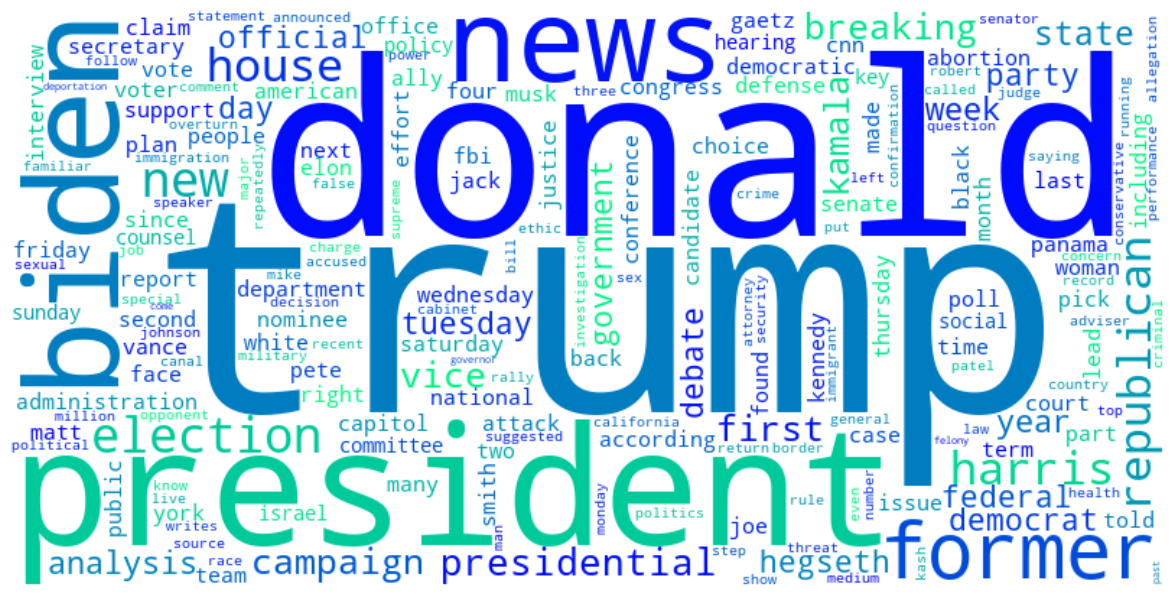

In [39]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

###############################################################################
# 1. Setup & Data Loading
###############################################################################
# Download necessary NLTK data files (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load your dataset
# Ensure that your CSV has the columns:
# "Post Text", "Post Timestamp", "Post Link", "average_sentiment"
df = pd.read_csv("average_sentiment_by_post.csv")

###############################################################################
# 2. Define Stopwords and Initialize Lemmatizer
###############################################################################
# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords
additional_stopwords = {
    'would', 'said', 'say', 'says', 'also', 'could', 'get', 'got',
    'like', 'might', 'must', 'need', 'one', 'see', 'should', 'still',
    'take', 'took', 'tell', 'tells', 'think', 'thinks', 'used', 'use',
    'using', 'way', 'ways', 'work', 'worked', 'working', 'works'
}

# Combine default and additional stopwords
stop_words = stop_words.union(additional_stopwords)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

###############################################################################
# 3. Create a Weighted Counter Based on Negative average_sentiment
###############################################################################
weighted_counts = Counter()

# Iterate over each post in the DataFrame
for index, row in df.iterrows():
    post_text = str(row['Post Text'])  # Ensure text is string
    sentiment = row['average_sentiment']
    
    try:
        sentiment = float(sentiment)  # Convert sentiment to float
    except ValueError:
        # If sentiment is not a number, skip this post
        continue
    
    # Focus only on negative sentiments
    if sentiment < 0:
        # Tokenize the post text
        tokens = word_tokenize(post_text)
        
        # Filter tokens: remove non-alphabetic tokens, stopwords, and short words
        filtered_words = [
            word.lower() for word in tokens
            if word.isalpha() and word.lower() not in stop_words and len(word) > 2
        ]
        
        # Lemmatize the filtered words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        
        # Accumulate the absolute sentiment for each word
        for word in lemmatized_words:
            weighted_counts[word] += abs(sentiment)

###############################################################################
# 4. Inspect Top Weighted Words
###############################################################################
# Get the top 20 words associated with negative sentiments
most_common_words = weighted_counts.most_common(20)
print("Top 20 words by cumulative negative sentiment score:")
for word, total_neg_sentiment in most_common_words:
    print(f"{word}: {total_neg_sentiment:.2f}")

###############################################################################
# 5. Generate the Word Cloud from Weighted Frequencies
###############################################################################
# Create the Word Cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='winter',              # Use a red color map to emphasize negativity
    max_words=200,                # Maximum number of words in the cloud
    normalize_plurals=True        # Normalize plural forms
).generate_from_frequencies(weighted_counts)

###############################################################################
# 6. Plot the Word Cloud
###############################################################################
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###############################################################################
# 7. (Optional) Save the Word Cloud to a File
###############################################################################
# Uncomment the line below to save the word cloud image
# wordcloud.to_file("negative_sentiment_wordcloud.png")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Top 20 words by weighted sentiment score:
attend: 0.54
nadler: 0.53
pardoned: 0.47
tax: 0.42
steel: 0.40
democracy: 0.37
giving: 0.36
loan: 0.34
decided: 0.32
judiciary: 0.32
chairman: 0.30
mourning: 0.29
jerrold: 0.29
heeding: 0.29
already: 0.28
dnc: 0.28
endorse: 0.27
grown: 0.27
spokesperson: 0.27
orbit: 0.25


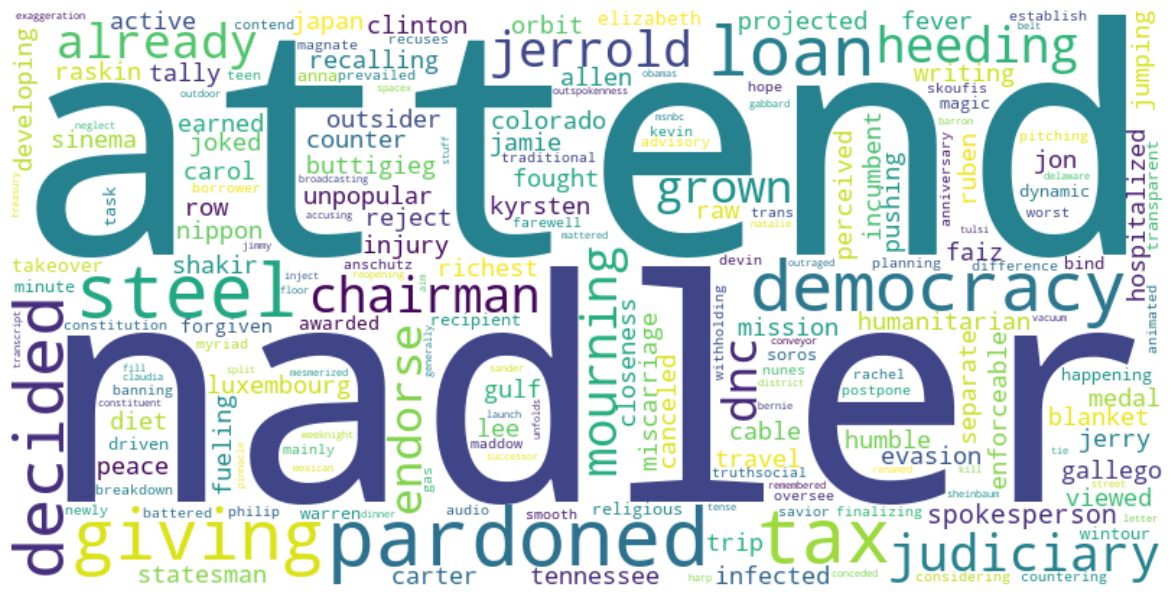

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

###############################################################################
# 1. Setup & Data Loading
###############################################################################
# If you haven't already downloaded the needed NLTK data, do so:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Read your dataset (CSV) with the columns: 
#    "Post Text","Post Timestamp","Post Link","average_sentiment"
df = pd.read_csv("average_sentiment_by_post.csv")

###############################################################################
# 2. Define Stopwords and Initialize Lemmatizer
###############################################################################
stop_words = set(stopwords.words('english'))

# Custom stopwords you wish to exclude
additional_stopwords = {
    'would', 'said', 'say', 'says', 'also', 'could', 'get', 'got',
    'like', 'might', 'must', 'need', 'one', 'see', 'should', 'still',
    'take', 'took', 'tell', 'tells', 'think', 'thinks', 'used', 'use',
    'using', 'way', 'ways', 'work', 'worked', 'working', 'works'
}

stop_words = stop_words.union(additional_stopwords)

lemmatizer = WordNetLemmatizer()

###############################################################################
# 3. Create a Weighted Counter Based on average_sentiment
###############################################################################
weighted_counts = Counter()

# Iterate over each row (i.e. each post)
for index, row in df.iterrows():
    post_text = str(row['Post Text'])
    sentiment = float(row['average_sentiment'])  # ensure it's numeric

    # Tokenize the post
    tokens = word_tokenize(post_text)

    # Filter tokens (remove non-alphabetic, short words, stopwords, etc.)
    filtered_words = [
        w.lower() for w in tokens
        if w.isalpha() and len(w) > 2 and w.lower() not in stop_words
    ]

    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # For each word, add this post's sentiment score to the Counter
    for word in lemmatized_words:
        weighted_counts[word] += sentiment

###############################################################################
# 4. Inspect or Print Top Weighted Words
###############################################################################
most_common_words = weighted_counts.most_common(20)
print("Top 20 words by weighted sentiment score:")
for word, total_sentiment in most_common_words:
    print(f"{word}: {total_sentiment:.2f}")

###############################################################################
# 5. Generate the Word Cloud from Weighted Frequencies
###############################################################################
# The word sizes in the cloud will scale according to the summed sentiment score
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate_from_frequencies(weighted_counts)

###############################################################################
# 6. Plot the Word Cloud
###############################################################################
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


[1, 8, 2, 1, 7, 6, 7, 4, 3, 4, 0, 3, 4, 7, 4, 1]
[6, 8, 7, 5, 7, 7, 8, 7, 12, 14, 9, 4, 13, 11, 14, 2]
[6, 9, 10, 5, 3, 4, 2, 11, 3, 2, 4, 4, 2, 2, 4, 0]
[3, 6, 9, 3, 5, 9, 3, 12, 5, 4, 11, 5, 7, 4, 6, 0]
[0, 3, 1, 5, 4, 6, 4, 10, 4, 0, 5, 2, 4, 6, 12, 1]
[0, 7, 4, 10, 9, 6, 6, 11, 10, 2, 6, 8, 9, 11, 16, 6]
{'whiskers': [<matplotlib.lines.Line2D object at 0x000001E9ED654260>, <matplotlib.lines.Line2D object at 0x000001E9ED6568A0>, <matplotlib.lines.Line2D object at 0x000001E9ED729340>, <matplotlib.lines.Line2D object at 0x000001E9ED7286E0>, <matplotlib.lines.Line2D object at 0x000001E9ED728F80>, <matplotlib.lines.Line2D object at 0x000001E9ED72BEF0>, <matplotlib.lines.Line2D object at 0x000001E9E8862210>, <matplotlib.lines.Line2D object at 0x000001E9EBAC8110>, <matplotlib.lines.Line2D object at 0x000001E9EBAC8E00>, <matplotlib.lines.Line2D object at 0x000001E9EBAC9760>, <matplotlib.lines.Line2D object at 0x000001E9EBACA5D0>, <matplotlib.lines.Line2D object at 0x000001E9EBACA780>], 'ca

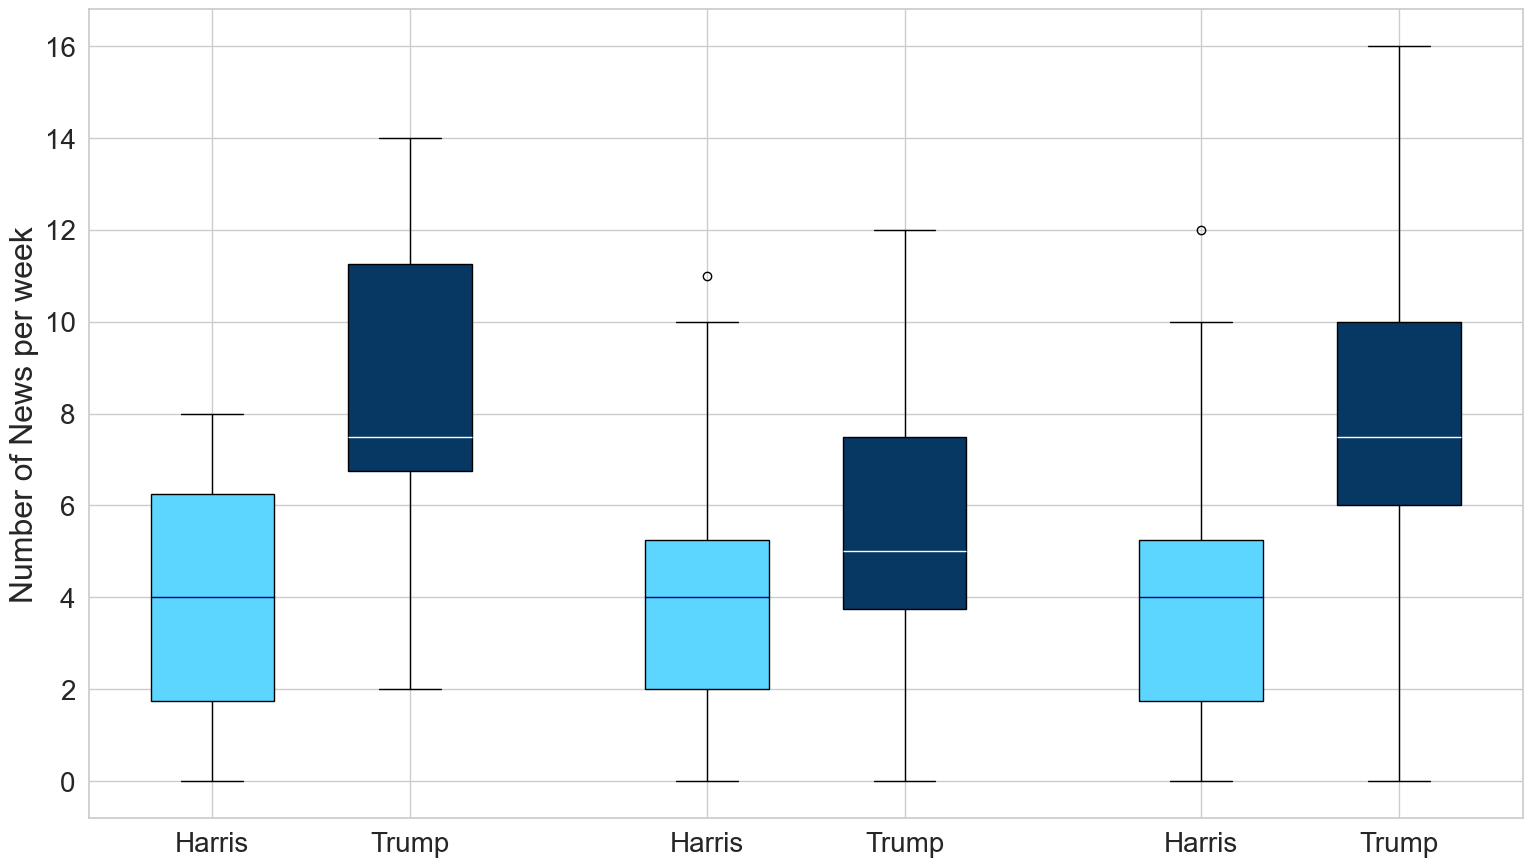

In [38]:
import scipy.stats as stats
from datetime import datetime
from pprint import pprint

def t_test(input_file):
    data = pd.read_csv(input_file)
    data = data[['Post Text', 'Post Timestamp']].drop_duplicates()
    data['Post Timestamp'] = pd.to_datetime(
        data['Post Timestamp']).dt.tz_localize(None)

    start_date = datetime(2024, 7, 25)
    end_date = datetime(2024, 11, 5)

    data = data[(data['Post Timestamp'] >= start_date)
                & (data['Post Timestamp'] <= end_date)]
    data['Week'] = data['Post Timestamp'].dt.isocalendar().week

    kamala_posts = data[data['Post Text'].str.contains(
        'kamala' or 'harris', case=False, na=False)]
    trump_posts = data[data['Post Text'].str.contains(
        'trump' or "donald", case=False, na=False)]

    kamala_weekly = kamala_posts.groupby('Week').size()
    trump_weekly = trump_posts.groupby('Week').size()

    weeks = range(start_date.isocalendar()[1], end_date.isocalendar()[1] + 1)
    kamala_counts = list(kamala_weekly.reindex(weeks, fill_value=0))
    trump_counts = list(trump_weekly.reindex(weeks, fill_value=0))
    

    pprint(kamala_counts)
    pprint(trump_counts)

    return kamala_counts, trump_counts, stats.ttest_ind(a=kamala_counts, b= trump_counts, equal_var=False)



km_counts_CNN, tp_counts_CNN, test_CNN = t_test("politics_posts_and_replies_CNN.csv")

km_counts_TNYT, tp_counts_TNYT, test_TNYT = t_test("politics_posts_and_replies_TNYT.csv")

km_counts_TWP, tp_counts_TWP, test_TWP = t_test("politics_posts_and_replies_TWP.csv")


data = [km_counts_CNN, tp_counts_CNN,km_counts_TNYT, tp_counts_TNYT,km_counts_TWP, tp_counts_TWP]

labels = ["Harris","Trump","Harris","Trump","Harris","Trump"]

colors = [(92/255,214/255,255/255,1),(7/255,55/255,99/255,1),(92/255,214/255,255/255,1),(7/255,55/255,99/255,1),(92/255,214/255,255/255,1),(7/255,55/255,99/255,1)]

positions = [0.5,1.3,2.5,3.3,4.5,5.3]

fig, ax = plt.subplots()


size = 20

ax.set_ylabel("Number of News per week", fontsize =size+3)
bplot = ax.boxplot(data,patch_artist=True, tick_labels=labels,positions=positions)

for patch, color in zip(bplot["boxes"],colors):
    patch.set_facecolor(color)

colors = ["darkblue","white","darkblue","white","darkblue","white"]


for median, color in zip(bplot["medians"],colors):
    median.set_color(color)

print(bplot)


ax.tick_params(axis='both', which='major', labelsize=size)

fig.set_size_inches(18.5, 10.5)


plt.show()




    

In [90]:
alpha = 0.05
print(f"CNN kamala test p-value:",stats.normaltest(km_counts_CNN).pvalue >= alpha)
print(f"CNN trump test p-value:",stats.normaltest(tp_counts_CNN).pvalue >= alpha)
print(f"TNYT kamala test p-value:",stats.normaltest(km_counts_TNYT).pvalue >= alpha)
print(f"TNYT kamala test p-value:",stats.normaltest(km_counts_TNYT).pvalue >= alpha)
print(f"TWP kamala test p-value:",stats.normaltest(km_counts_TWP).pvalue >= alpha)
print(f"TWP kamala test p-value:",stats.normaltest(km_counts_TWP).pvalue >= alpha)

CNN kamala test p-value: True
CNN trump test p-value: True
TNYT kamala test p-value: True
TNYT kamala test p-value: True
TWP kamala test p-value: True
TWP kamala test p-value: True


In [111]:
print(test_CNN)
print(test_TNYT)
print(test_TWP)

TtestResult(statistic=np.float64(-4.125865615274749), pvalue=np.float64(0.000315773391397922), df=np.float64(27.065954591363774))
TtestResult(statistic=np.float64(-1.1760200709138167), pvalue=np.float64(0.24884028119970059), df=np.float64(29.98326464061071))
TtestResult(statistic=np.float64(-2.65995867183653), pvalue=np.float64(0.012534131633403391), df=np.float64(29.349981839836055))


In [113]:
import pandas as pd
import os

# List of dataset filenames
dataset_files = [
    "politics_posts_metrics_TNYT.csv",
    "politics_posts_metrics_TWP.csv",
    "politics_posts_metrics_FOX.csv",
    "politics_posts_metrics_CNN.csv",
    "politics_posts_metrics_NBC.csv"
]

# Initialize an empty list to store individual DataFrames
data_frames = []

# Load each dataset
for file in dataset_files:
    try:
        df = pd.read_csv(file)
        data_frames.append(df)
        print(f"Loaded {file} with {len(df)} records.")
    except FileNotFoundError:
        print(f"File {file} not found. Please check the path and filename.")
    except pd.errors.EmptyDataError:
        print(f"File {file} is empty.")
    except Exception as e:
        print(f"An error occurred while reading {file}: {e}")

# Combine all DataFrames into one
combined_df = pd.concat(data_frames, ignore_index=True)
print(f"\nTotal records after combining: {len(combined_df)}")

# Define the expected columns
expected_columns = [
    "Post Text",
    "Post Timestamp",
    "Post Link",
    "Number of Comments",
    "Number of Likes",
    "Number of Reposts"
]

# Check for missing columns
missing_columns = set(expected_columns) - set(combined_df.columns)
if missing_columns:
    print(f"Missing columns in the combined dataset: {missing_columns}")
    # You can choose to handle missing columns here
else:
    print("All expected columns are present.")

# Convert relevant columns to numeric, coerce errors to NaN
combined_df["Number of Comments"] = pd.to_numeric(combined_df["Number of Comments"], errors='coerce')
combined_df["Number of Likes"] = pd.to_numeric(combined_df["Number of Likes"], errors='coerce')
combined_df["Number of Reposts"] = pd.to_numeric(combined_df["Number of Reposts"], errors='coerce')

# Fill NaN values with 0 (assuming missing values imply zero interactions)
combined_df.fillna({
    "Number of Comments": 0,
    "Number of Likes": 0,
    "Number of Reposts": 0
}, inplace=True)

# Verify the data types
print("\nData types after conversion:")
print(combined_df.dtypes)

# Method 1: Aggregate Totals and Compute the Overall Ratio
total_comments = combined_df["Number of Comments"].sum()
total_likes = combined_df["Number of Likes"].sum()
total_reposts = combined_df["Number of Reposts"].sum()

print("\n--- Aggregate Totals ---")
print(f"Total Number of Comments: {total_comments}")
print(f"Total Number of Likes: {total_likes}")
print(f"Total Number of Reposts: {total_reposts}")

print("\n--- Average Ratio of Comments : Likes : Reposts ---")
print(f"{total_comments} : {total_likes} : {total_reposts}")

# Method 2: Calculate Per-Post Averages and Then Compute the Ratio
average_comments = combined_df["Number of Comments"].mean()
average_likes = combined_df["Number of Likes"].mean()
average_reposts = combined_df["Number of Reposts"].mean()

print("\n--- Per-Post Averages ---")
print(f"Average Number of Comments per Post: {average_comments:.2f}")
print(f"Average Number of Likes per Post: {average_likes:.2f}")
print(f"Average Number of Reposts per Post: {average_reposts:.2f}")

print("\n--- Average Ratio of Comments : Likes : Reposts (Per Post) ---")
print(f"{average_comments:.2f} : {average_likes:.2f} : {average_reposts:.2f}")

# Optional: Handle Division by Zero
if total_likes != 0:
    comments_per_like = total_comments / total_likes
    print(f"\nComments per Like: {comments_per_like:.4f}")
else:
    print("\nCannot compute Comments per Like: Total Likes is zero.")

if total_reposts != 0:
    comments_per_repost = total_comments / total_reposts
    print(f"Comments per Repost: {comments_per_repost:.4f}")
else:
    print("Cannot compute Comments per Repost: Total Reposts is zero.")


Loaded politics_posts_metrics_TNYT.csv with 1380 records.
Loaded politics_posts_metrics_TWP.csv with 909 records.
Loaded politics_posts_metrics_FOX.csv with 2166 records.
Loaded politics_posts_metrics_CNN.csv with 894 records.
Loaded politics_posts_metrics_NBC.csv with 457 records.

Total records after combining: 5806
All expected columns are present.

Data types after conversion:
Post Text             object
Post Timestamp        object
Post Link             object
Number of Comments     int64
Number of Likes        int64
Number of Reposts      int64
dtype: object

--- Aggregate Totals ---
Total Number of Comments: 121721
Total Number of Likes: 609797
Total Number of Reposts: 135904

--- Average Ratio of Comments : Likes : Reposts ---
121721 : 609797 : 135904

--- Per-Post Averages ---
Average Number of Comments per Post: 20.96
Average Number of Likes per Post: 105.03
Average Number of Reposts per Post: 23.41

--- Average Ratio of Comments : Likes : Reposts (Per Post) ---
20.96 : 105.

In [114]:
import pandas as pd
import os

# List of dataset filenames
dataset_files = [
    "politics_posts_metrics_TNYT.csv",
    "politics_posts_metrics_TWP.csv",
    "politics_posts_metrics_FOX.csv",
    "politics_posts_metrics_CNN.csv",
    "politics_posts_metrics_NBC.csv"
]

# Directory where your datasets are located
# If they're in the current working directory, you can leave it as an empty string
data_dir = ""  # e.g., "/path/to/your/datasets"

# Function to calculate and add the Popularity Score
def add_popularity_score(file_path, output_path=None):
    """
    Adds a Popularity Score ('N') to the dataset based on the formula:
    N = 5 * Number of Comments + 5 * Number of Reposts + 1 * Number of Likes

    Parameters:
    - file_path: Path to the input CSV file.
    - output_path: Path to save the updated CSV file. If None, overwrites the original file.
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        print(f"Processing file: {file_path}")

        # Ensure the required columns exist
        required_columns = ["Number of Comments", "Number of Likes", "Number of Reposts"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"  ❌ Missing columns: {missing_columns}. Skipping this file.")
            return

        # Convert relevant columns to numeric, coercing errors to NaN
        for col in required_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Fill NaN values with 0 (assuming missing values imply zero interactions)
        df[required_columns] = df[required_columns].fillna(0)

        # Calculate the Popularity Score ('N')
        df['N'] = 5 * df["Number of Comments"] + 5 * df["Number of Reposts"] + 1 * df["Number of Likes"]

        # Optional: Reorder columns to place 'N' at the end or desired position
        # For example, placing 'N' after 'Number of Reposts':
        # cols = list(df.columns)
        # insert_at = cols.index("Number of Reposts") + 1
        # cols.insert(insert_at, "N")
        # df = df[cols]

        # Define the output file path
        if output_path is None:
            # Overwrite the original file
            output_file = file_path
        else:
            # Save to the specified output path
            output_file = output_path

        # Save the updated DataFrame to a new CSV file
        df.to_csv(output_file, index=False, encoding="utf-8")
        print(f"  ✅ Added 'N' column and saved to: {output_file}\n")

    except FileNotFoundError:
        print(f"  ❌ File not found: {file_path}. Please check the path and filename.")
    except pd.errors.EmptyDataError:
        print(f"  ❌ File is empty: {file_path}. Skipping this file.")
    except Exception as e:
        print(f"  ❌ An error occurred while processing {file_path}: {e}")

# Process each dataset
for file in dataset_files:
    input_path = os.path.join(data_dir, file)
    
    # Option 1: Overwrite the original files
    # Uncomment the following line if you want to overwrite
    # add_popularity_score(input_path)
    
    # Option 2: Save updated files with a new suffix to avoid overwriting
    file_name, file_ext = os.path.splitext(file)
    output_file = f"{file_name}_with_N{file_ext}"
    output_path = os.path.join(data_dir, output_file)
    add_popularity_score(input_path, output_path)

print("All files have been processed.")


Processing file: politics_posts_metrics_TNYT.csv
  ✅ Added 'N' column and saved to: politics_posts_metrics_TNYT_with_N.csv

Processing file: politics_posts_metrics_TWP.csv
  ✅ Added 'N' column and saved to: politics_posts_metrics_TWP_with_N.csv

Processing file: politics_posts_metrics_FOX.csv
  ✅ Added 'N' column and saved to: politics_posts_metrics_FOX_with_N.csv

Processing file: politics_posts_metrics_CNN.csv
  ✅ Added 'N' column and saved to: politics_posts_metrics_CNN_with_N.csv

Processing file: politics_posts_metrics_NBC.csv
  ✅ Added 'N' column and saved to: politics_posts_metrics_NBC_with_N.csv

All files have been processed.


In [16]:
import pandas as pd
import os

# ------------------------------
# 1. Define Journal Followers
# ------------------------------
# Replace the follower counts with the actual numbers for each journal
journal_followers = {
    'TNYT': 954400,   # The New York Times
    'TWP': 653700,      # The Washington Post
    'FOX': 12700,      # Fox News
    'CNN': 490700,     # CNN
    'NBC': 69400       # NBC
}

# ------------------------------
# 2. Define Dataset Filenames
# ------------------------------
dataset_files = [
    "politics_posts_metrics_TNYT_with_N.csv",
    "politics_posts_metrics_TWP_with_N.csv",
    "politics_posts_metrics_FOX_with_N.csv",
    "politics_posts_metrics_CNN_with_N.csv",
    "politics_posts_metrics_NBC_with_N.csv"
]


# ------------------------------
# 3. Import Libraries
# ------------------------------
import pandas as pd
import os

# ------------------------------
# 4. Initialize List to Store DataFrames
# ------------------------------
data_frames = []

# ------------------------------
# 5. Load, Process, and Append Each Dataset
# ------------------------------
for file in dataset_files:
    try:
        # Read the CSV file
        df = pd.read_csv(file, parse_dates=['Post Timestamp'])
        print(f"Loaded {file} with {len(df)} records.")

        
        # Extract journal identifier from the filename
        # Assumes filename format: politics_posts_metrics_JOURNAL.csv
        journal = list(str(file).strip(""))[-12] # e.g., 'TNYT' from 'politics_posts_metrics_TNYT.csv'


        if journal == "N":
            journal = "CNN"
        elif journal == "X":
            journal = "FOX"
        elif journal == "C":
            journal = "NBC"
        elif journal == "T":
            journal = "TNYT"
        elif journal == "P":
            journal = "TWP"
        else:
            print(journal)
        
        # Add the 'J' column based on the journal's followers
        if journal in journal_followers:
            df['J'] = journal_followers[journal]
        else:
            print(f"Warning: Journal '{journal}' not found in 'journal_followers' dictionary. Assigning J=0.")
            df['J'] = 0  # Assign 0 or another default value if journal not found
        
        # Optionally, add a 'Journal' column for clarity
        df['Journal'] = journal
        
        # Append the processed DataFrame to the list
        data_frames.append(df)
        
    except FileNotFoundError:
        print(f"Error: File '{file}' not found. Please check the path and filename.")
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file}' is empty. Skipping this file.")
    except Exception as e:
        print(f"An unexpected error occurred while processing '{file}': {e}")

# ------------------------------
# 6. Concatenate All DataFrames
# ------------------------------
if not data_frames:
    print("No data frames to concatenate. Exiting script.")
    exit()

# Concatenate all DataFrames into one
combined_df = pd.concat(data_frames, ignore_index=True)
print(f"\nTotal records after concatenation: {len(combined_df)}")

# ------------------------------
# 7. Save the Combined DataFrame to a New CSV
# ------------------------------
# Define the output filename
output_filename = "combined_politics_posts.csv"

# Save the combined DataFrame to a CSV file
combined_df.to_csv(output_filename, index=False, encoding="utf-8")
print(f"Combined data saved to '{output_filename}'.")


Loaded politics_posts_metrics_TNYT_with_N.csv with 1380 records.
Loaded politics_posts_metrics_TWP_with_N.csv with 909 records.
Loaded politics_posts_metrics_FOX_with_N.csv with 2166 records.
Loaded politics_posts_metrics_CNN_with_N.csv with 894 records.
Loaded politics_posts_metrics_NBC_with_N.csv with 457 records.

Total records after concatenation: 5806
Combined data saved to 'combined_politics_posts.csv'.


Dataset 'combined_politics_posts.csv' carregado com sucesso. Total de registros: 5806
Aviso: Algumas entradas em 'Post Timestamp' não puderam ser convertidas e foram definidas como NaT.
Registros após filtragem de datas: 4179
Substituindo 'Post Text' vazio pelo 'Post Link' para o jornal 'FOX'.
Registros após remoção de duplicatas: 4179


C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\1588880758.py:81: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period('W-MON')\



Calculando popularidade para a keyword: 'Biden'
  Total de posts contendo 'Biden': 713
  Popularidade calculada e adicionada para 'Biden'.

Calculando popularidade para a keyword: 'Trump'
  Total de posts contendo 'Trump': 1873


C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\1588880758.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  popularity = popularity.fillna(0)
C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\1588880758.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  popularity = popularity.fillna(0)
C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\1588880758.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future 

  Popularidade calculada e adicionada para 'Trump'.

Calculando popularidade para a keyword: 'Kamala'
  Total de posts contendo 'Kamala': 269
  Popularidade calculada e adicionada para 'Kamala'.
Plotado popularidade para 'Biden'.
Plotado popularidade para 'Trump'.
Plotado popularidade para 'Kamala'.


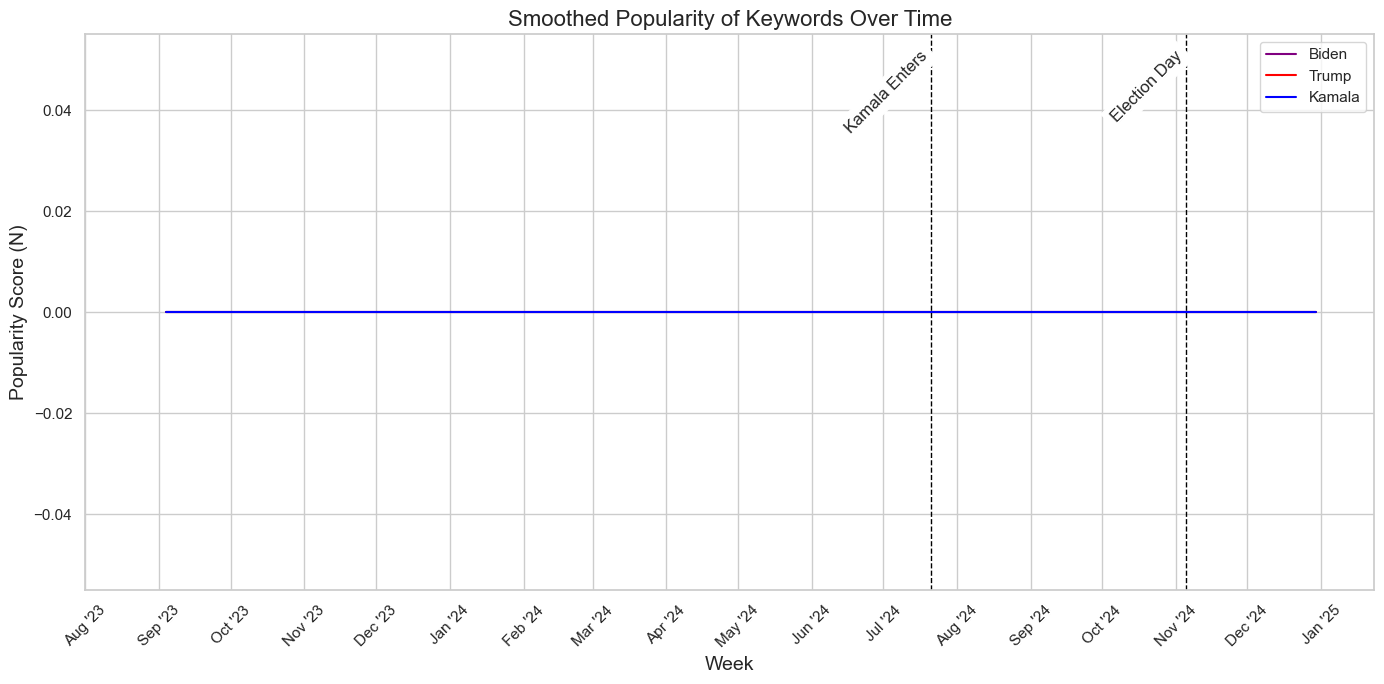

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ------------------------------
# 1. Definir o Caminho para o Dataset Combinado
# ------------------------------
# Substitua pelo caminho correto do seu arquivo combinado
combined_csv_path = "combined_politics_posts.csv"

# ------------------------------
# 2. Definir Keywords e Cores
# ------------------------------
# Liste as keywords que você deseja analisar
keywords = ['Biden', 'Trump', 'Kamala']

# Atribua uma cor para cada keyword
colors = ['purple', 'red', 'blue']  # Ajuste conforme necessário

# ------------------------------
# 3. Definir Datas de Eventos Importantes
# ------------------------------
event_dates = {
    "Kamala Enters": "2024-07-21",
    "Election Day": "2024-11-05"
}

# ------------------------------
# 4. Carregar o Dataset Combinado
# ------------------------------
try:
    df = pd.read_csv(combined_csv_path, parse_dates=['Post Timestamp'])
    print(f"Dataset '{combined_csv_path}' carregado com sucesso. Total de registros: {len(df)}")
except FileNotFoundError:
    print(f"Erro: O arquivo '{combined_csv_path}' não foi encontrado. Verifique o caminho e o nome do arquivo.")
    exit()
except pd.errors.EmptyDataError:
    print(f"Erro: O arquivo '{combined_csv_path}' está vazio.")
    exit()
except Exception as e:
    print(f"Erro ao ler o arquivo '{combined_csv_path}': {e}")
    exit()

# ------------------------------
# 5. Verificar e Converter 'Post Timestamp' para Datetime
# ------------------------------
if not pd.api.types.is_datetime64_any_dtype(df['Post Timestamp']):
    df['Post Timestamp'] = pd.to_datetime(df['Post Timestamp'], errors='coerce')
    if df['Post Timestamp'].isnull().any():
        print("Aviso: Algumas entradas em 'Post Timestamp' não puderam ser convertidas e foram definidas como NaT.")

# ------------------------------
# 6. Filtrar o Intervalo de Datas
# ------------------------------
df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]
print(f"Registros após filtragem de datas: {len(df)}")

# ------------------------------
# 7. Substituir 'Post Text' Vazio para FOX
# ------------------------------
# Verifique se o dataset combinado inclui múltiplos jornais; se sim, substitua para cada jornal individualmente
for journal in df['Journal'].unique():
    if journal.upper() == "FOX":
        mask = df['Journal'] == journal
        # Substituir apenas onde 'Post Text' está vazio ou nulo
        empty_text_mask = df['Post Text'].isna() | (df['Post Text'].str.strip() == "")
        df.loc[mask & empty_text_mask, 'Post Text'] = df.loc[mask & empty_text_mask, 'Post Link']
        print(f"Substituindo 'Post Text' vazio pelo 'Post Link' para o jornal '{journal}'.")

# ------------------------------
# 8. Remover Duplicatas
# ------------------------------
df = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])
print(f"Registros após remoção de duplicatas: {len(df)}")

# ------------------------------
# 9. Definir 'Start of Week'
# ------------------------------
df['Start of Week'] = df['Post Timestamp']\
                       .dt.to_period('W-MON')\
                       .apply(lambda r: r.start_time)

# ------------------------------
# 10. Calcular Popularidade para Cada Keyword
# ------------------------------
# Inicializar um DataFrame para armazenar os resultados
popularity_over_time = pd.DataFrame()

# Iterar sobre cada keyword
for keyword, color in zip(keywords, colors):
    print(f"\nCalculando popularidade para a keyword: '{keyword}'")
    
    # Filtrar posts que contêm a keyword (case-insensitive)
    keyword_posts = df[df['Post Text'].str.contains(keyword, case=False, na=False)]
    print(f"  Total de posts contendo '{keyword}': {len(keyword_posts)}")
    
    # Agrupar por 'Start of Week' e 'Journal' e somar 'N' para posts com a keyword
    grouped_keyword = keyword_posts.groupby(['Start of Week', 'Journal'])['N'].sum().reset_index()
    
    # Agrupar por 'Start of Week' e 'Journal' e somar 'N' para todos os posts
    grouped_all = df.groupby(['Start of Week', 'Journal'])['N'].sum().reset_index()
    
    # Multiplicar por 'J' (número de seguidores) para cada grupo
    grouped_keyword = grouped_keyword.merge(df[['Journal', 'J']].drop_duplicates(), on='Journal', how='left')
    grouped_keyword['Weighted_N_keyword'] = grouped_keyword['J'] * grouped_keyword['N']
    
    grouped_all = grouped_all.merge(df[['Journal', 'J']].drop_duplicates(), on='Journal', how='left')
    grouped_all['Weighted_N_all'] = grouped_all['J'] * grouped_all['N']
    
    # Agrupar por 'Start of Week' para somar os valores ponderados
    numerator = grouped_keyword.groupby('Start of Week')['Weighted_N_keyword'].sum()
    denominator = grouped_all.groupby('Start of Week')['Weighted_N_all'].sum()
    
    # Criar uma sequência de semanas completas no intervalo para reindexar
    all_weeks = pd.date_range(start='2023-09-01', end='2025-01-01', freq='W-MON')
    numerator = numerator.reindex(all_weeks, fill_value=0)
    denominator = denominator.reindex(all_weeks, fill_value=0)
    
    # Calcular a popularidade
    popularity = numerator / denominator.replace(0, pd.NA)
    popularity = popularity.fillna(0)
    
    # Aplicar suavização com média móvel
    window = 4  # Defina o tamanho da janela conforme necessário
    smoothed = popularity.rolling(window=window, min_periods=1, center=True).mean()
    
    # Adicionar os resultados ao DataFrame principal
    temp_df = pd.DataFrame({
        'Start of Week': all_weeks,
        'Keyword': keyword,
        'Popularity': smoothed.values
    })
    
    popularity_over_time = pd.concat([popularity_over_time, temp_df], ignore_index=True)
    print(f"  Popularidade calculada e adicionada para '{keyword}'.")

# ------------------------------
# 11. Plotar os Resultados
# ------------------------------
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))

# Iterar sobre cada keyword para plotar
for keyword, color in zip(keywords, colors):
    keyword_data = popularity_over_time[popularity_over_time['Keyword'] == keyword]
    ax.plot(keyword_data['Start of Week'], keyword_data['Popularity'], label=keyword, color=color)
    print(f"Plotado popularidade para '{keyword}'.")

# Definir título e rótulos dos eixos
ax.set_title('Smoothed Popularity of Keywords Over Time', fontsize=16)
ax.set_xlabel('Week', fontsize=14)
ax.set_ylabel('Popularity Score (N)', fontsize=14)

# Adicionar linhas verticais e anotações para eventos
ymax = ax.get_ylim()[1]

for event, date_str in event_dates.items():
    event_date = pd.Timestamp(date_str)
    ax.axvline(event_date, color='black', linestyle='--', linewidth=1)
    ax.text(event_date, ymax * 0.95, event,
            rotation=45,
            verticalalignment='top',
            horizontalalignment='right',
            backgroundcolor='white')

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

# Adicionar legenda e ajustar layout
ax.legend(loc="best")
plt.tight_layout()

# Exibir o gráfico
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\475701968.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period('W-MON')\
C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\475701968.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  popularity = popularity.fillna(0)
C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\475701968.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period('W-MON')\
C:\Users\gusta\AppData\Local\Temp\ipykernel_5216\475701968.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future beha

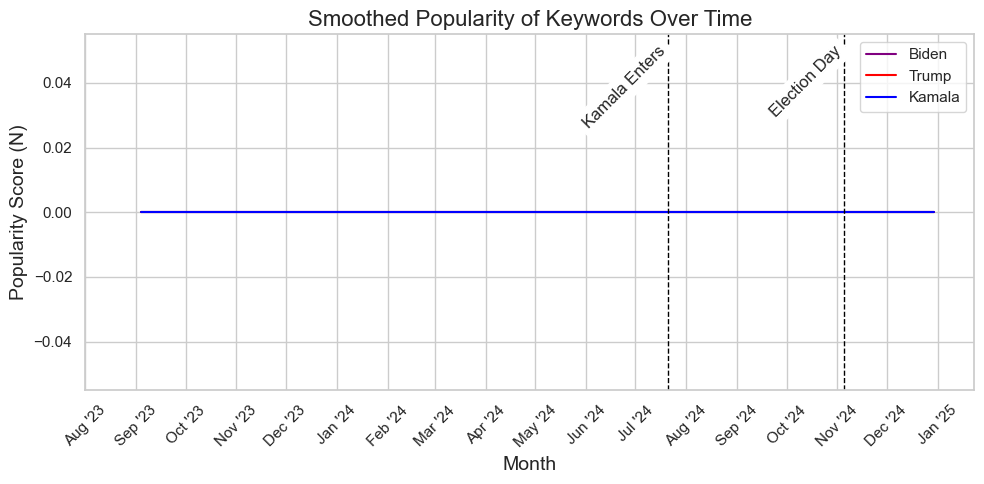

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_overall_keyword_popularity_weekly_smoothed(paths, keyword, color, ax, window=4):
    all_frames = []
    # Loop por cada arquivo para ler, filtrar e preparar os dados
    for path in paths:
        # Leia o CSV, parseando apenas 'Post Timestamp' como datetime
        df = pd.read_csv(path, parse_dates=['Post Timestamp'])
        
        # Filtrar o intervalo de datas
        df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]
        
        # Substitui 'Post Text' vazio ou nulo pelo 'Post Link' se o jornal for FOX
        fox_mask = df['Journal'].str.upper() == 'FOX'
        empty_text_mask = df['Post Text'].isna() | (df['Post Text'].str.strip() == "")
        df.loc[fox_mask & empty_text_mask, 'Post Text'] = df.loc[fox_mask & empty_text_mask, 'Post Link']
        
        # Remove duplicatas baseadas nas colunas especificadas
        unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])
        
        # Assegura que 'Post Timestamp' é do tipo datetime
        unique_posts['Post Timestamp'] = pd.to_datetime(unique_posts['Post Timestamp'], errors='coerce')
        unique_posts = unique_posts.dropna(subset=['Post Timestamp'])
        
        # Define o início da semana (segunda-feira)
        unique_posts['Start of Week'] = unique_posts['Post Timestamp']\
                                        .dt.to_period('W-MON')\
                                        .apply(lambda r: r.start_time)
        
        all_frames.append(unique_posts)

    # Combina dados de todos os datasets
    combined = pd.concat(all_frames, ignore_index=True)

    # Assegura que 'N' é numérico
    combined['N'] = pd.to_numeric(combined['N'], errors='coerce').fillna(0)

    # Filtra posts que contêm a palavra-chave (case-insensitive)
    keyword_posts = combined[combined['Post Text'].str.contains(keyword, case=False, na=False)]

    # Agrupa por 'Start of Week' e 'Journal' e soma 'N' para posts com a keyword
    grouped_keyword = keyword_posts.groupby(['Start of Week', 'Journal'])['N'].sum().reset_index()

    # Agrupa por 'Start of Week' e 'Journal' e soma 'N' para todos os posts
    grouped_all = combined.groupby(['Start of Week', 'Journal'])['N'].sum().reset_index()

    # Multiplica por 'J' (número de seguidores) para cada grupo
    grouped_keyword = grouped_keyword.merge(combined[['Journal', 'J']].drop_duplicates(), on='Journal', how='left')
    grouped_keyword['Weighted_N_keyword'] = grouped_keyword['J'] * grouped_keyword['N']

    grouped_all = grouped_all.merge(combined[['Journal', 'J']].drop_duplicates(), on='Journal', how='left')
    grouped_all['Weighted_N_all'] = grouped_all['J'] * grouped_all['N']

    # Agrupa por 'Start of Week' para somar os valores ponderados
    numerator = grouped_keyword.groupby('Start of Week')['Weighted_N_keyword'].sum()
    denominator = grouped_all.groupby('Start of Week')['Weighted_N_all'].sum()

    # Cria uma sequência de semanas completas no intervalo para reindexar
    all_weeks = pd.date_range(start='2023-09-01', end='2025-01-01', freq='W-MON')
    numerator = numerator.reindex(all_weeks, fill_value=0)
    denominator = denominator.reindex(all_weeks, fill_value=0)

    # Calcula a popularidade
    popularity = numerator / denominator.replace(0, pd.NA)
    popularity = popularity.fillna(0)

    # Aplica suavização com média móvel
    smoothed = popularity.rolling(window=window, min_periods=1, center=True).mean()

    # Plota a linha suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{keyword}", color=color)

# ------------------------------
# 2. Definir Lista de Caminhos para Seus Datasets
# ------------------------------
paths = [
    "combined_politics_posts.csv"  # Substitua pelo caminho correto do seu dataset combinado
]

# ------------------------------
# 3. Configuração do Plot
# ------------------------------
fig, ax = plt.subplots(figsize=(10,5))

# Define o tamanho da janela para a média móvel
w = 3  # Você pode ajustar este valor conforme necessário

# Defina as keywords e suas cores correspondentes
keywords = ['Biden', 'Trump', 'Kamala']
colors = ['purple', 'red', 'blue']  # Ajuste conforme necessário

# ------------------------------
# 4. Definir Datas de Eventos Importantes
# ------------------------------
event_dates = {
    "Kamala Enters": "2024-07-21",
    "Election Day": "2024-11-05"
}

# ------------------------------
# 5. Chamada da Função para Cada Keyword
# ------------------------------
plot_overall_keyword_popularity_weekly_smoothed(paths, "Biden", "purple", ax, window=w)
plot_overall_keyword_popularity_weekly_smoothed(paths, "Trump", "red", ax, window=w)
plot_overall_keyword_popularity_weekly_smoothed(paths, "Kamala", "blue", ax, window=w)

# ------------------------------
# 6. Personalização do Gráfico
# ------------------------------
# Definir título e rótulos dos eixos
ax.set_title('Smoothed Popularity of Keywords Over Time', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Popularity Score (N)', fontsize=14)

# Adicionar linhas verticais e anotações para eventos
ymax = ax.get_ylim()[1]

for event, date_str in event_dates.items():
    event_date = pd.Timestamp(date_str)
    ax.axvline(event_date, color='black', linestyle='--', linewidth=1)
    ax.text(event_date, ymax * 0.95, event,
            rotation=45,
            verticalalignment='top',
            horizontalalignment='right',
            backgroundcolor='white')

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

# Adicionar legenda e ajustar layout
ax.legend(loc="best")
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [33]:
# Defina os caminhos para os seus arquivos de palavras
positive_words_file = 'PositiveWords.txt'
negative_words_file = 'NegativeWords.txt'
engaging_words_file = 'EngagingWords.txt'

def extract_words(file_path):
    """
    Extrai as palavras de um arquivo no formato 'palavra: número' e retorna um conjunto de palavras.
    
    Parâmetros:
    - file_path: Caminho para o arquivo de texto.
    
    Retorna:
    - Um conjunto contendo as palavras extraídas.
    """
    words = set()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Remove espaços em branco e quebras de linha
            line = line.strip()
            if line:
                # Divide a linha pelo caractere ':' e pega a primeira parte (a palavra)
                word = line.split(':')[0].strip().lower()
                words.add(word)
    return words

# Extrai as palavras de cada arquivo
positive_words = extract_words(positive_words_file)
negative_words = extract_words(negative_words_file)
engaging_words = extract_words(engaging_words_file)

# Calcula as interseções
engaging_positive = engaging_words.intersection(positive_words)
engaging_negative = engaging_words.intersection(negative_words)

# Calcula as porcentagens
percentage_positive = (len(engaging_positive) / len(engaging_words)) * 100 if engaging_words else 0
percentage_negative = (len(engaging_negative) / len(engaging_words)) * 100 if engaging_words else 0

# Exibe os resultados
print(f"Total de palavras em EngagingWords: {len(engaging_words)}\n")

print(f"Palavras em EngagingWords e PositiveWords: {len(engaging_positive)}")
print(f"Porcentagem: {percentage_positive:.2f}%")
print("Palavras:", ', '.join(sorted(engaging_positive)), "\n")

print(f"Palavras em EngagingWords e NegativeWords: {len(engaging_negative)}")
print(f"Porcentagem: {percentage_negative:.2f}%")
print("Palavras:", ', '.join(sorted(engaging_negative)))


Total de palavras em EngagingWords: 60

Palavras em EngagingWords e PositiveWords: 0
Porcentagem: 0.00%
Palavras:  

Palavras em EngagingWords e NegativeWords: 32
Porcentagem: 53.33%
Palavras: administration, analysis, breaking, case, cnn, defense, department, donald, election, federal, first, former, gaetz, government, harris, hegseth, house, lead, matt, new, news, official, pete, pick, president, presidential, report, republican, trump, trying, woman, year


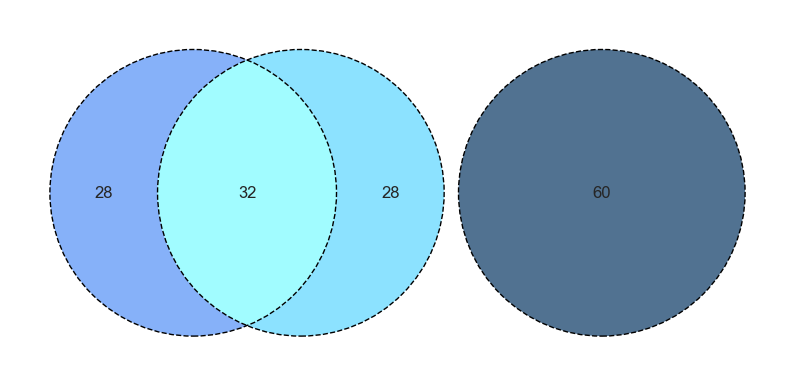

In [56]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

# Define os conjuntos
set1 = engaging_words
set2 = positive_words
set3 = negative_words

# Cria o diagrama de Venn
plt.figure(figsize=(10,8))
venn = venn3([set1, set2, set3], ('', '', ''), set_colors=((92/255,214/255,255/255,0.5), (7/255,55/255,99/255,0.5), (83/255, 145/255, 247/255,0.5)), alpha=0.7)

# Opcional: adicionar círculos estilizados
c = venn3_circles([set1, set2, set3],linestyle="dashed", linewidth=1)




# Adiciona um título
#plt.title('Interseção entre EngagingWords, PositiveWords e NegativeWords', fontsize=16)

# Exibe o diagrama
plt.show()
